In [1]:
import os
import keras
import keras.backend as K
import numpy as np
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.model_selection import StratifiedShuffleSplit
from keras.models import Model

from data import read_crop_list, load_structured_sample
from eval import eval_model_one_hot
from metrics import f1, f1_loss
from models import model_stack_lstm, model_Conv1D, model_Conv1D_LSTM
from training import train, create_training_folder
from keras.utils import plot_model
from training import train, create_training_folder, create_callbacks, step_decay_exp
from tcn import TCN, tcn_full_summary

import keras.backend as K
from sklearn.model_selection import StratifiedShuffleSplit
from tcn import TCN

from tensorflow.keras.layers import Embedding, Dense, Input, BatchNormalization, Conv1D,MaxPool1D, Concatenate,\
Activation,GlobalAveragePooling1D, Dropout
from tensorflow.keras.models import Model,Sequential
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.python.keras.utils.vis_utils import plot_model


from training import train, create_training_folder


Using TensorFlow backend.


In [2]:
from training import train, create_training_folder

tf.keras.utils.get_custom_objects()
tf.keras.utils.get_custom_objects()['f1'] = f1
tf.keras.utils.get_custom_objects()['f1_loss'] = f1_loss

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""


In [3]:

df_crops, vocab = read_crop_list()

sample = load_structured_sample()
# sample = load_undersampled_data()
print("Using sample size: {}".format(sample.shape))

y = sample[:, 11]
X = sample[:, 3:11]
sequence_length = X.shape[-1]

# X = one_hot_encoding_X(X, vocab_size=vocab_size)
y = to_categorical(y)
# random train-test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    

print(np.unique(y_train).shape)

print("===Train/test size: {}, {}".format(len(y_train), len(y_test)))

Using sample size: (31373, 12)
(2,)
===Train/test size: 21961, 9412


In [4]:
X.shape

(31373, 8)

In [5]:
crop_names = df_crops["description"].values.tolist()
crop_list = df_crops["idx"].values.tolist()

In [6]:

def _shortcut_layer(input_tensor, out_tensor):
    shortcut_y = Conv1D(filters=int(out_tensor.shape[-1]), kernel_size=1,
                        padding='same', use_bias=False)(input_tensor)
    shortcut_y = BatchNormalization()(shortcut_y)
    x = Add()([shortcut_y, out_tensor])
    x = Activation('relu')(x)
    return x

 
def _inception_module(input_tensor, stride=1, activation='linear', bottleneck_size=32, nb_filters=32, 
                      use_bottleneck=False, dropout=0):

    if use_bottleneck and int(input_tensor.shape[-1]) > 1:
        input_inception = Conv1D(filters=bottleneck_size, kernel_size=1,
                                 padding='same', activation=activation, use_bias=False)(input_tensor)
    else:
        input_inception = input_tensor

    # kernel_size_s = [3, 5, 8, 11, 17]
    # kernel_size_s = [kernel_size // (2 ** i) for i in range(3)]
    kernel_size_s = [1, 2, 4, 8]

    conv_list = []

    for i in range(len(kernel_size_s)):
        conv_list.append(Conv1D(filters=nb_filters, kernel_size=kernel_size_s[i],
                                strides=stride, padding='same',
                                activation=activation, use_bias=False)(input_inception))

    max_pool_1 = MaxPool1D(pool_size=3, strides=stride, padding='same')(input_tensor)

    conv_6 = Conv1D(filters=nb_filters, kernel_size=1,
                    padding='same', activation=activation, use_bias=False)(max_pool_1)
    conv_list.append(conv_6)

    x = Concatenate(axis=2)(conv_list)
    x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)
    if dropout > 0:
        x = Dropout(dropout)(x)
    return x


def model_inceptionTime(input_shape, nb_filters=32, use_residual=False, use_bottleneck=True, depth=6,
                        kernel_size=41, bottleneck_size=32):
   

    input_layer = Input(input_shape)
    x = input_layer
    x = Embedding(output_dim=20, input_dim=27, input_length=8)(x)
        
    input_res = input_layer

    for d in range(depth):
        print("dpeth: {}".format(d))
        x = _inception_module(x, use_bottleneck=use_bottleneck)
        
        if use_residual and d % 3 == 2:
            x = _shortcut_layer(input_res, x)
            input_res = x

    gap_layer = GlobalAveragePooling1D()(x)
#     gap_layer = Dropout(0.3)(gap_layer)
    output_layer = Dense(27, activation='relu')(gap_layer)
    model = Model(inputs=input_layer, outputs=output_layer)
    return model


dpeth: 0
dpeth: 1
dpeth: 2
dpeth: 3
dpeth: 4
dpeth: 5


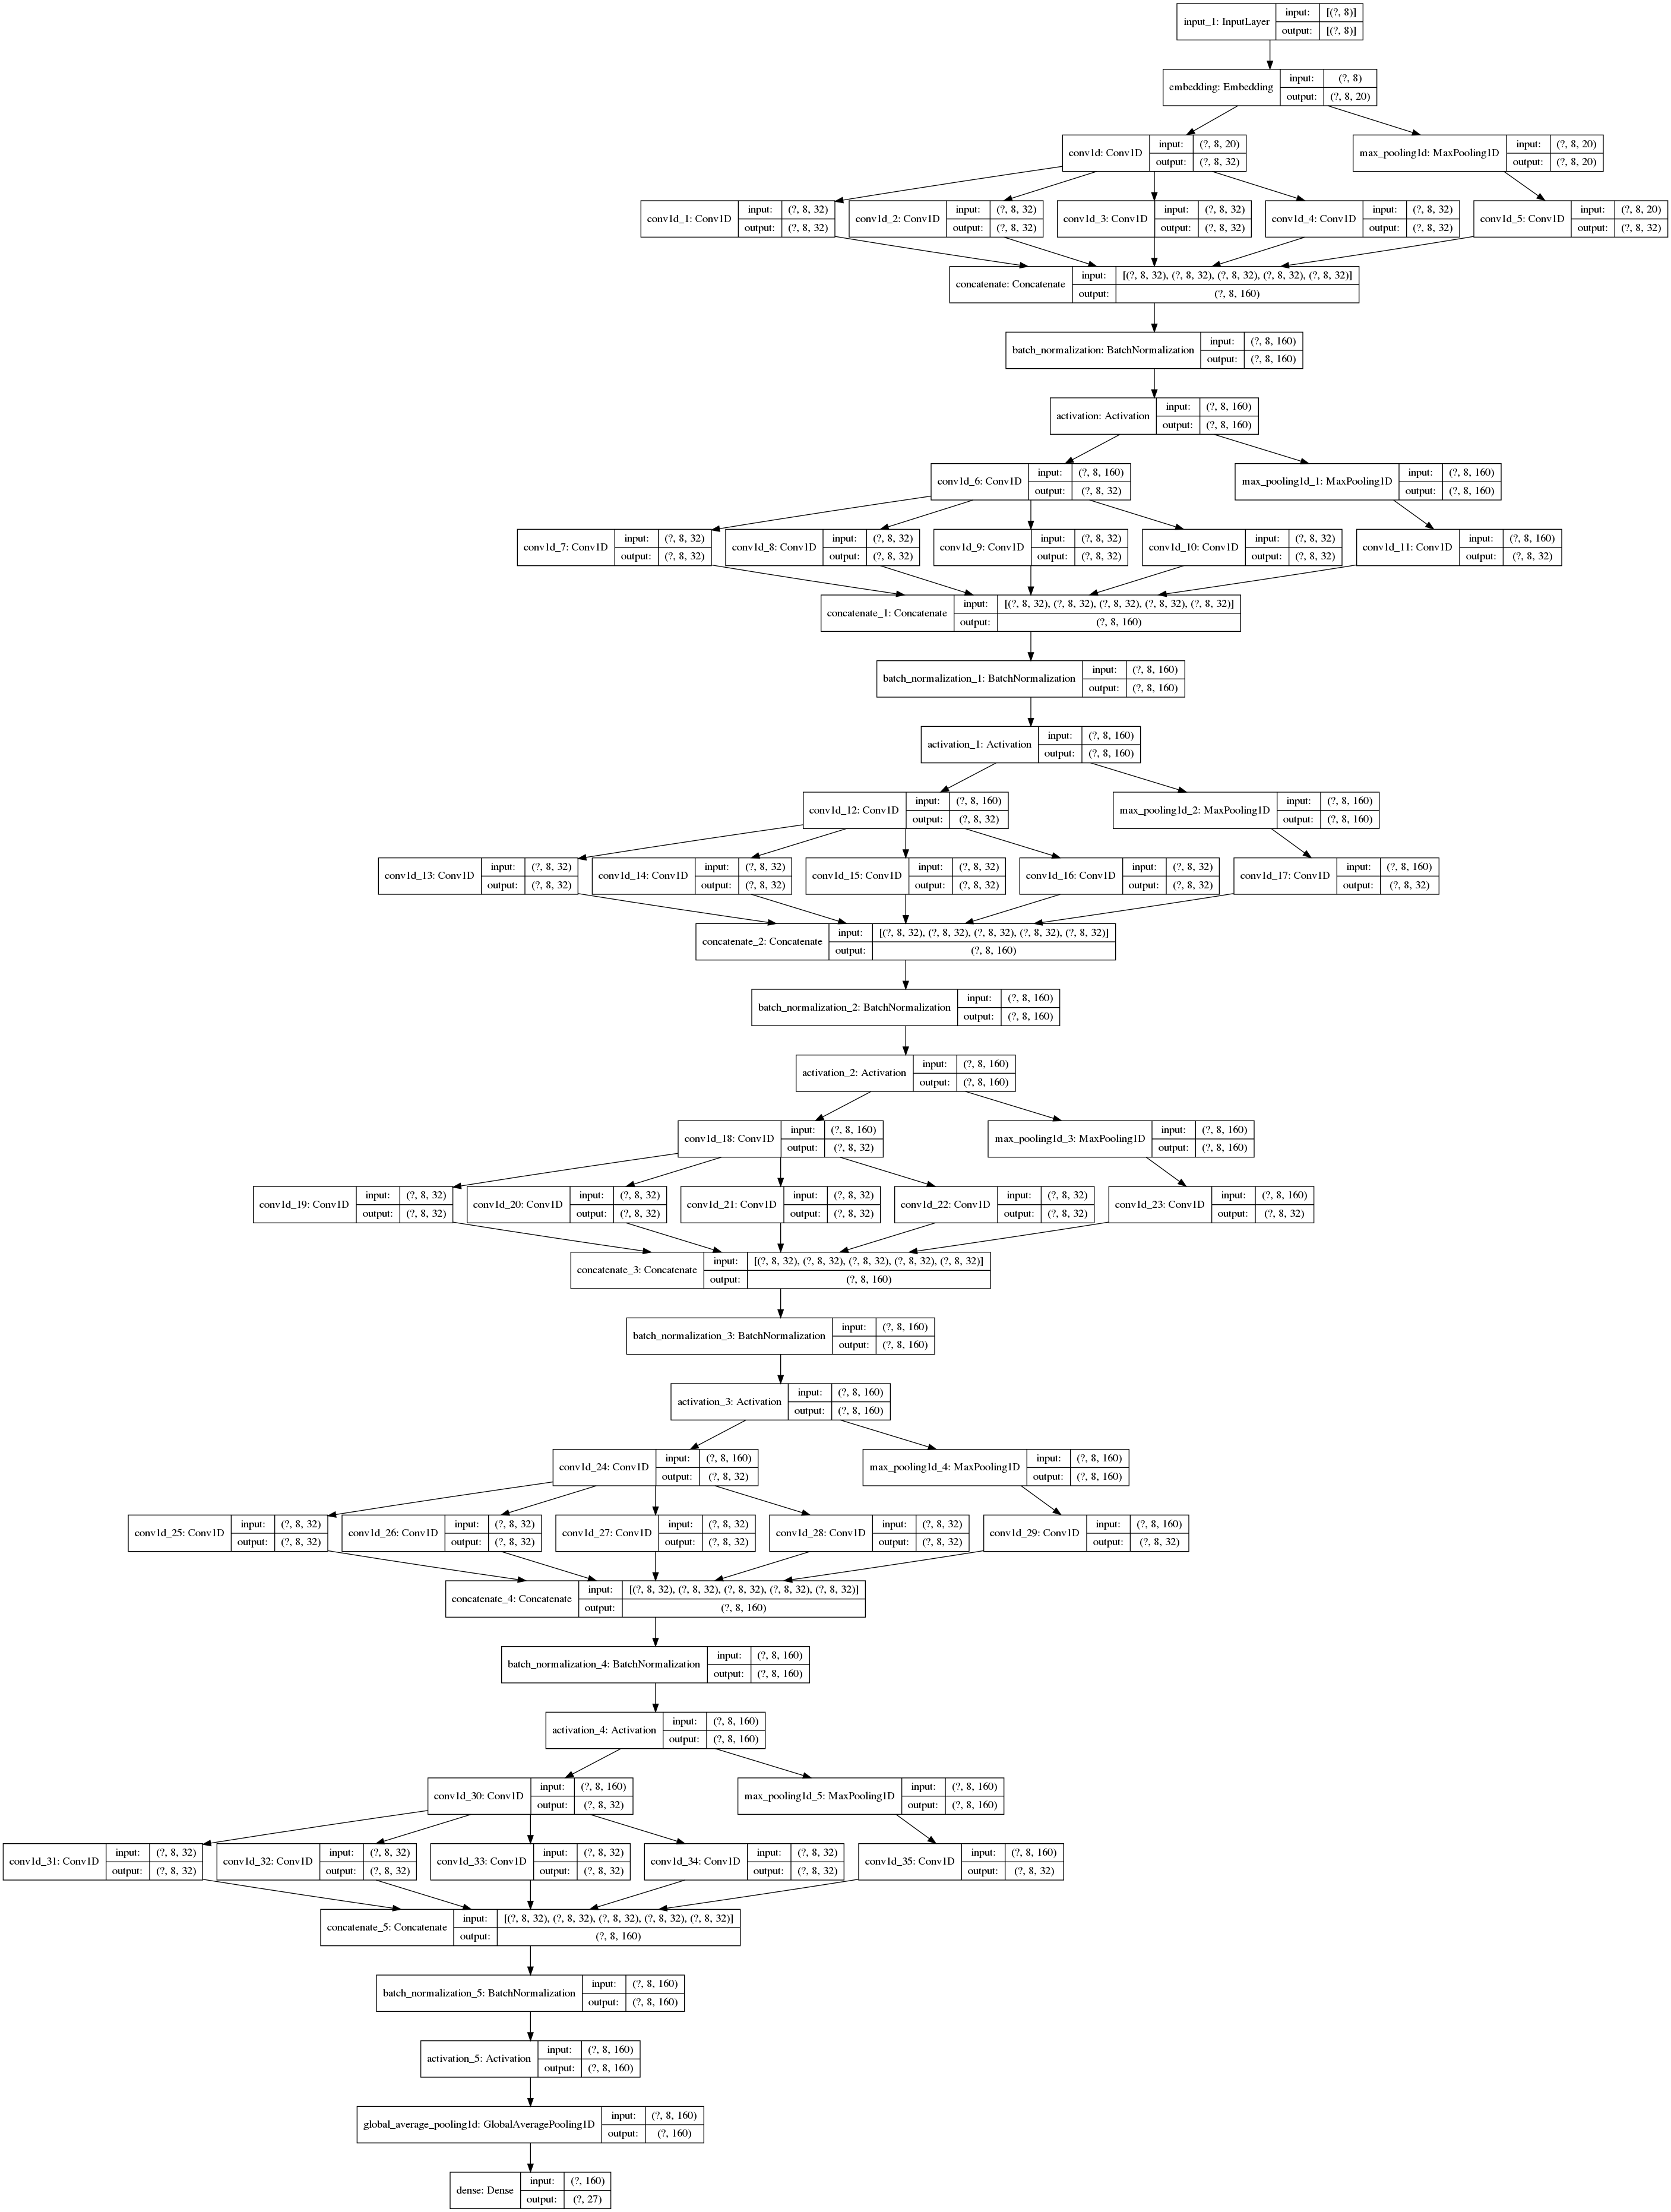

In [8]:

K.clear_session()
sequence_length = 8
vocab_size, embedding_size = (27, 20)
# model = hydrid(sequence_length, (vocab_size, embedding_size))
model = model_inceptionTime(sequence_length)

# input_shape = (None, 8)
# model = model_inceptionTime(input_shape)

tag = "inceptionTime"

plot_model(model, show_shapes = True)

In [8]:
K.clear_session()

training_params = {
    'loss': f1_loss,
    'optimizer': 'rmsprop',
    'metrics': [f1],
    'run_eagerly': False
}

model.compile(**training_params)

epochs=100
exp_base = "conv1d"
folder = create_training_folder(exp_base, tag)

lr_scheduller = tf.keras.callbacks.LearningRateScheduler(step_decay_exp)
#lr_scheduller = tf.keras.callbacks.ReduceLROnPlateau(step_decay_exp)
lr_scheduller = None
callbacks = create_callbacks(folder, tensor_board=True, monitor_metric="val_f1", monitor_mode="max",
                     lr_scheduller=lr_scheduller)


train(model, X_train, y_train, X_test, y_test, epochs=epochs, callbacks=callbacks)

# save model
model_folder = '{}/model'.format(folder)
model.save(model_folder)

# evaluate
y_hat = model.predict(X_test)
eval_model_one_hot(folder, y_test, y_hat, crop_list, crop_names)


/home/gus/workspaces/wpy/venvs/mathor/lib/python3.6/site-packages/keras/callbacks/tensorboard_v2.py:97: UserWarning: The TensorBoard callback does not support gradients display when using TensorFlow 2.0. The `write_grads` argument is ignored.
  warnings.warn('The TensorBoard callback does not support '


Epoch 1/100

Epoch 00001: val_f1 improved from -inf to 0.60187, saving model to /home/gus/workspaces/wpy/IACapstone/results/conv1d/20200802_190923_inceptionTime
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/gus/workspaces/wpy/IACapstone/results/conv1d/20200802_190923_inceptionTime/assets
687/687 - 12s - loss: 0.4534 - f1: 0.5482 - val_loss: 0.3975 - val_f1: 0.6019
Epoch 2/100

Epoch 00002: val_f1 improved from 0.60187 to 0.63716, saving model to /home/gus/workspaces/wpy/IACapstone/results/conv1d/20200802_190923_inceptionTime
INFO:tensorflow:Assets written to: /home/gus/workspaces/wpy/IACapstone/results/conv1d/20200802_190923_inceptionTime/assets
687/687 - 11s - loss: 0.3397 - f1: 0.6600 - val_loss: 0.3607 - val_f1: 0.6372
Epoch 3/100

Epoch 00003: val_f1 improved from 0.63716 to 0.65682, saving model to /home/gus/workspaces/wpy/IACapstone/results/conv1d/20200802_190923_inceptionTime
INFO:tensorflow:Assets writt

Epoch 35/100

Epoch 00035: val_f1 did not improve from 0.71210
687/687 - 12s - loss: 0.1588 - f1: 0.8407 - val_loss: 0.2981 - val_f1: 0.6998
Epoch 36/100

Epoch 00036: val_f1 did not improve from 0.71210
687/687 - 8s - loss: 0.1647 - f1: 0.8348 - val_loss: 0.2920 - val_f1: 0.7061
Epoch 37/100

Epoch 00037: val_f1 did not improve from 0.71210
687/687 - 8s - loss: 0.1701 - f1: 0.8293 - val_loss: 0.3047 - val_f1: 0.6934
Epoch 38/100


KeyboardInterrupt: 

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
eval_model_one_hot(folder, y_test, y_hat, crop_list, crop_names)